In [1]:
import sys
import os
import glob
# sys.path.append('../')
# sys.path.append('../modules/')
# sys.path.append('../util/')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import random
from natsort import natsorted
from tqdm.notebook import tqdm

from SFM_Finetune import models_Segmentation
from SFM_Pretrain import models_mae
from modules.modeling.deeplab import *
from modules.modeling.Unet_models import *
from util.metrics import *

pwd = os.getcwd()

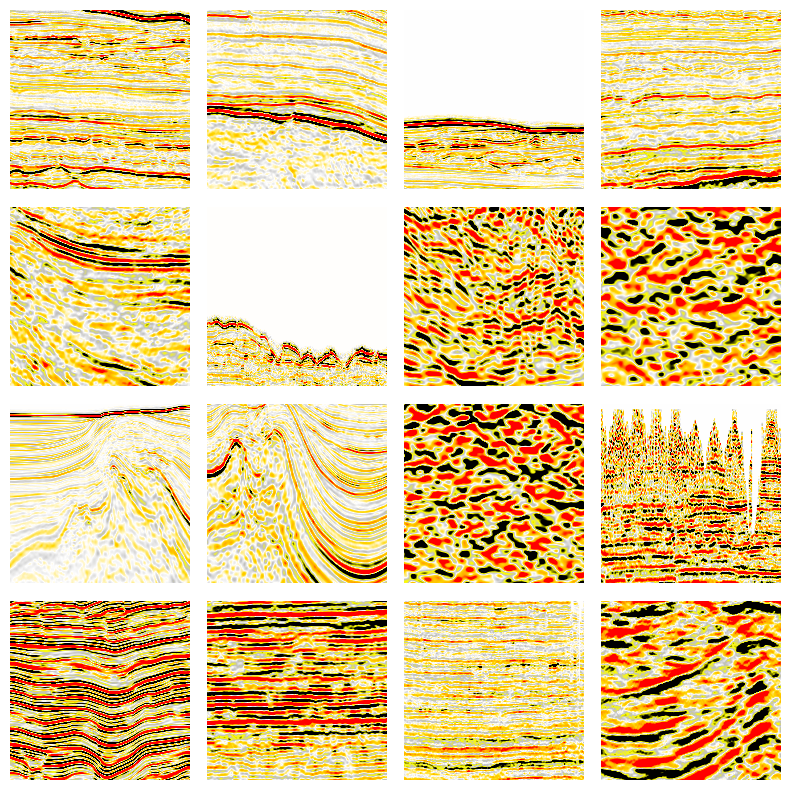

In [2]:
color_list = ['black','yellow','silver','white','gold','orange','red']
cmap = mpl.colors.LinearSegmentedColormap.from_list('colormap_name', color_list)


data_path = os.path.join(pwd, 'mae_data_more_small')
data_files = natsorted(glob.glob(os.path.join(data_path, '*.dat')))
# selected_files = random.sample(data_files, 16) # Random Select files to show
selected_files = data_files[:16]

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=np.array((10, 10)) * 0.8)
for i, ax in enumerate(axes.flatten()):
    with open(selected_files[i], 'rb') as f:
        data = np.fromfile(f, dtype=np.single)
        img_size = int(np.sqrt(data.size))
        data = data.reshape((img_size, img_size))
        ax.imshow(data, cmap=cmap, vmin=np.min(data)/3,vmax=-np.min(data)/3)
        ax.axis('off')
# 显示整个图像
plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

In [3]:
def merge_dat_files_to_npy(data_path, output_dir, output_base_name='merged_data', batch_size=100):
    # 获取目录下所有的.dat文件
    dat_files = [f for f in os.listdir(data_path) if f.endswith('.dat')]
    
    # 打乱文件列表
    random.shuffle(dat_files)

    # dat_files = natsorted([f for f in os.listdir(data_path) if f.endswith('.dat')])
    # print(dat_files)
    
    # 创建输出目录，如果不存在的话
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # 分组并合并文件
    for i in range(0, len(dat_files), batch_size):
        # 选择当前批次的文件
        files_batch = dat_files[i:i+batch_size]
        
        # 创建一个空的列表来存放所有数组
        arrays_list = []
        
        # 遍历当前批次的文件，读取内容并添加到数组列表中
        for file_name in files_batch:
            file_path = os.path.join(data_path, file_name)
            # 加载.dat文件为numpy数组
            array = np.fromfile(file_path, dtype=np.single)
            arrays_list.append(array)
        
        # 合并所有数组到一个大数组
        merged_array = np.concatenate(arrays_list, axis=0)
        # print(merged_array.shape)
        # print(type(merged_array))
        
        # 保存合并后的数组为.npy文件
        output_file = os.path.join(output_dir, f'{output_base_name}_{i//batch_size}.dat')
        merged_array.tofile(output_file)
        # np.save(output_file, merged_array)
        

# 使用函数，例如合并每200个文件
data_path = os.path.join(pwd, 'mae_data_more_small')
output_path = os.path.join(pwd, 'merged_data')
merge_dat_files_to_npy(data_path, output_path , batch_size=45)

In [4]:
# # import os

# # def merge_dat_files(data_path, output_filename):
# #     # 获取当前目录下所有的 .dat 文件
# #     dat_files = []
# #     for f in tqdm(os.listdir(data_path) 
# #         if f.endswith('.dat'):
# #             dat_files.append(f)
# #     # dat_files = [f for f in os.listdir(data_path) if f.endswith('.dat')]
# #     random.shuffle(dat_files)

# #     # 打开输出文件，准备写入
# #     with open(output_filename, 'wb') as outfile:
# #         # 遍历每一个 .dat 文件
# #         for file_name in tqdm(dat_files):
# #             file_path = os.path.join(data_path, file_name)
# #             # print(f"Merging {file_name} into {output_filename}")
# #             # 打开当前 .dat 文件，以二进制模式读取
# #             with open(file_path, 'rb') as infile:
# #                 # 一次性读取整个文件内容
# #                 data = infile.read()
# #                 # 将读取的数据写入到输出文件
# #                 outfile.write(data)

# # # 调用函数，指定输出文件名
# # data_path = os.path.join(pwd, 'mae_data_more_small')
# # merge_dat_files(data_path, 'merged.dat')



# import os
# import random
# import concurrent.futures
# from tqdm import tqdm
# from tqdm.contrib.concurrent import thread_map

# def read_and_write_file(data_path, file_name, outfile):
#     file_path = os.path.join(data_path, file_name)
#     with open(file_path, 'rb') as infile:
#         data = infile.read()
#     outfile.write(data)

# def merge_dat_files_parallel(data_path, output_filename):
#     # 获取当前目录下所有的 .dat 文件
#     dat_files = []
#     for f in tqdm(os.listdir(data_path)):
#         if f.endswith('.dat'):
#             dat_files.append(f)
#     # dat_files = [f for f in os.listdir(data_path) if f.endswith('.dat')]
#     random.shuffle(dat_files)

#     # 打开输出文件，准备写入
#     with open(output_filename, 'wb') as outfile:
#         # 使用线程池并行处理，并添加进度条
#         thread_map(lambda file_name: read_and_write_file(data_path, file_name, outfile), dat_files, max_workers=None, desc='Merging files', unit='files')

# # 调用函数，指定输出文件名
# data_path = os.path.join(os.getcwd(), 'mae_data_more')
# merge_dat_files_parallel(data_path, 'merged.dat')

200704


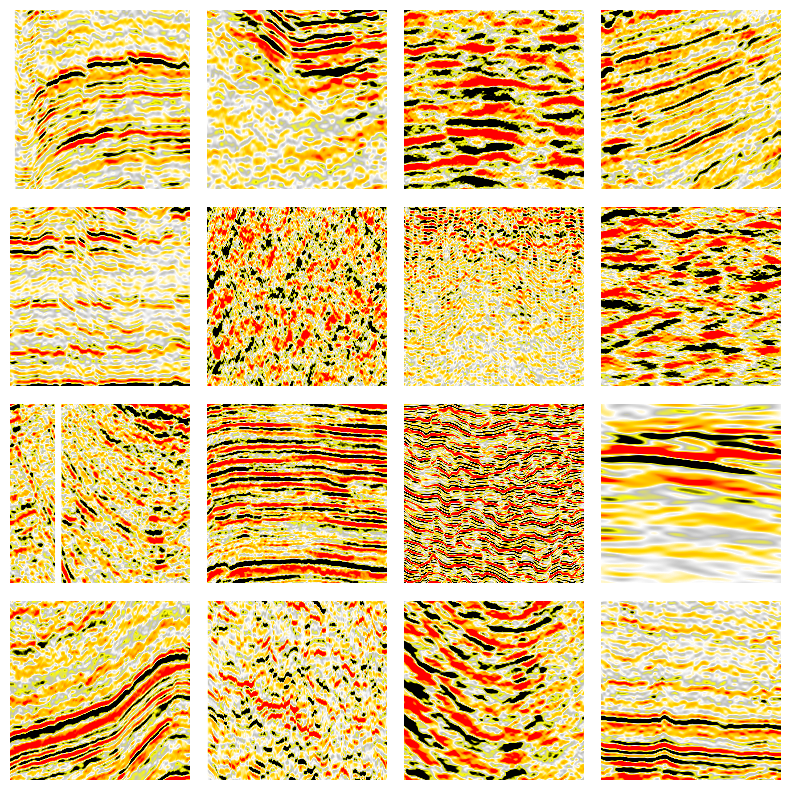

In [22]:
# output_path = os.path.join(pwd, 'merged_data')
# dat_path = os.path.join(output_path, 'merged_data_0.dat')
dat_path = "/home/zhangji/sdb1_data/Geophysics_data/mae_data_more.dat"
input_size = 224

color_list = ['black','yellow','silver','white','gold','orange','red']
cmap = mpl.colors.LinearSegmentedColormap.from_list('colormap_name', color_list)
read_len = input_size * input_size * np.single().itemsize
print(read_len)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=np.array((10, 10)) * 0.8)
with open(dat_path, 'rb') as binary_file:
    binary_file.seek(read_len * 2286406)
    for i, axi in enumerate(axes.flatten()):
        chunk = binary_file.read(read_len)        
        if not chunk:
            break     

        data = np.frombuffer(chunk, dtype=np.single())
        data = data.reshape((input_size, input_size))
        axi.imshow(data, cmap=cmap, vmin=np.min(data)/3,vmax=-np.min(data)/3)
        axi.axis('off')
plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

In [18]:
# output_path = os.path.join(pwd, 'merged_data')
# dat_path = os.path.join(output_path, 'merged_data_0.dat')
dat_path = "/home/zhangji/sdb1_data/Geophysics_data/mae_data_more.dat"
input_size = 224

color_list = ['black','yellow','silver','white','gold','orange','red']
cmap = mpl.colors.LinearSegmentedColormap.from_list('colormap_name', color_list)
read_len = input_size * input_size * np.single().itemsize 
print(read_len)
with open(dat_path, 'rb') as binary_file:
    # 移动文件指针到文件末尾
    binary_file.seek(0, 2)
    # 获取当前位置，即为文件长度
    file_length = binary_file.tell()
#     assert file_length % read_len == 0, f"The file length is not divisible by read_len"
    print("文件长度（字节）:", file_length, file_length / read_len, file_length % read_len == 0)

200704
文件长度（字节）: 458894041088 2286422.0 True


In [23]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [33]:
dataset_train[0][0][0]

(224, 224)

len(self.file_list) 2286422


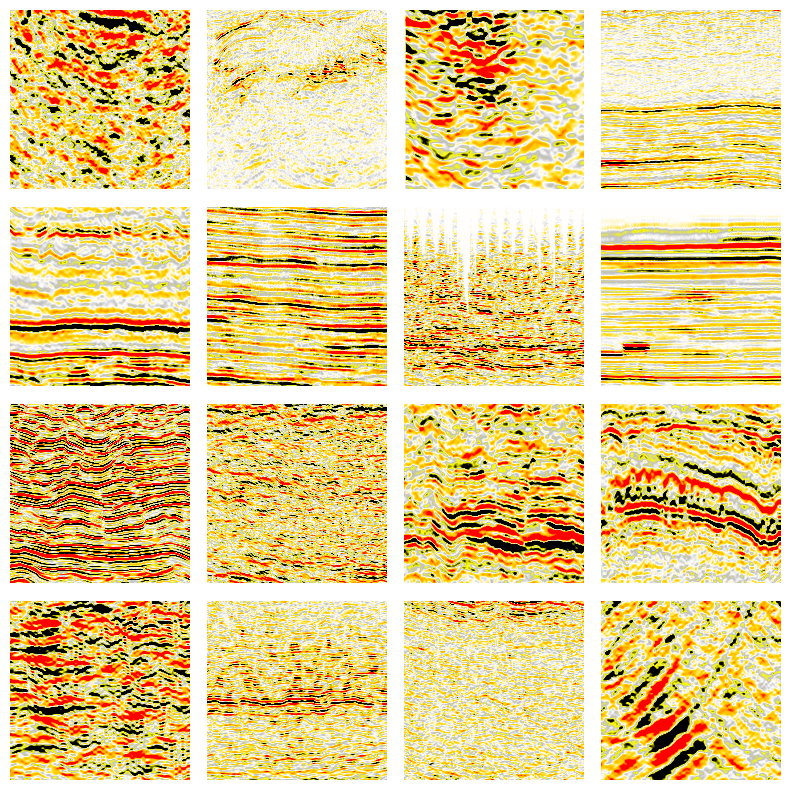

In [36]:
# varify SeismicSet_singleFile

from util.datasets import *

# output_path = os.path.join(pwd, 'merged_data')
# dat_path = os.path.join(output_path, 'merged_data_0.dat')
dat_path = "/home/zhangji/sdb1_data/Geophysics_data/mae_data_more.dat"
input_size = 224

dataset_train = SeismicSet_singleFile(dat_path, input_size)

color_list = ['black','yellow','silver','white','gold','orange','red']
cmap = mpl.colors.LinearSegmentedColormap.from_list('colormap_name', color_list)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=np.array((10, 10)) * 0.8)
for i, axi in enumerate(axes.flatten()):
    data = dataset_train[i][0][0]
    axi.imshow(data, cmap=cmap, vmin=np.min(data)/3,vmax=-np.min(data)/3)
    axi.axis('off')
plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()